# Wrangling Data From Bay Area Bike Share Published Data - Bikes

### Import Packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import numpy as np

import seaborn as sns
sns.set()

<p> Set some notebook variables, makes the notebook 95% width of the screen for easier viewing</p>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<p> Set some global font sizes for plots </p>

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [5]:
print('Started Loading Trips Data...')
file_path_slug = '../clean_data/bayareabikeshare/trip_data_cleaned.csv'
file_list = glob(file_path_slug)

trips_df = pd.DataFrame()

counter = 1
chunks = []

for file in file_list:
    
    chunk_counter = 1
    num_chunks = math.ceil(sum(1 for row in open(file, 'r'))/10000)
    
    for chunk in pd.read_csv(file, chunksize=10000, iterator=True, index_col=0):
        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1
        
    print('Finished file! (%d of %d)' % (counter, len(file_list)))
    counter += 1
    
trips_df = pd.concat(chunks)
print('Data Loaded Successfully!')

Started Loading Trips Data...
	[15:53:15.838653] finished chunk 1 of 96
	[15:53:16.284703] finished chunk 10 of 96
	[15:53:16.778074] finished chunk 20 of 96
	[15:53:17.236644] finished chunk 30 of 96
	[15:53:17.662034] finished chunk 40 of 96
	[15:53:18.925235] finished chunk 50 of 96
	[15:53:19.428162] finished chunk 60 of 96
	[15:53:19.934182] finished chunk 70 of 96
	[15:53:20.416370] finished chunk 80 of 96
	[15:53:20.854079] finished chunk 90 of 96
	[15:53:21.087917] finished chunk 96 of 96
Finished file! (1 of 1)
Data Loaded Successfully!


# Isolate Bike Data
<p>Each Trip Recorded inclues the bike_id, extract data we need for this smaller dataset</p>

In [6]:
bike_df = pd.DataFrame()
bike_df['first_trip'] = pd.to_datetime(trips_df.groupby('bike_id')['start_date'].min())
bike_df['latest_trip']  = pd.to_datetime(trips_df.groupby('bike_id')['start_date'].max())
bike_df['trip_count'] = trips_df.groupby('bike_id')['start_date'].count()

bike_df['days_in_service'] = (bike_df['latest_trip'] - bike_df['first_trip']).dt.days

last_recorded_trip = bike_df.latest_trip.max()
bike_df['days_since_last_trip'] = (last_recorded_trip - bike_df.latest_trip).dt.days

bike_df['total_usage_time'] = trips_df.groupby('bike_id')['duration'].sum()
bike_df['median_usage_time_per_trip'] = trips_df.groupby('bike_id')['duration'].median()
bike_df['mean_usage_time_per_trip'] = trips_df.groupby('bike_id')['duration'].mean()

bike_df['mean_rides_per_day'] = bike_df['trip_count'] / bike_df['days_in_service']

# bikes with at least 1500 rides are in category 1, else category 0
bike_df['ride_num_category'] = bike_df.trip_count.apply(lambda x: 1 if x >= 1500 else 0)

bike_df.head()

,first_trip,latest_trip,trip_count,days_in_service,days_since_last_trip,total_usage_time,median_usage_time_per_trip,mean_usage_time_per_trip,mean_rides_per_day,ride_num_category
bike_id,,,,,,,,,,
9,2013-08-29 12:02:00,2016-08-19 20:09:00,396,1086,12,215883,424.0,545.159091,0.364641,0
10,2013-09-01 13:47:00,2016-08-31 16:53:00,353,1095,0,179512,343.0,508.532578,0.322374,0
11,2013-08-29 20:11:00,2016-08-28 09:35:00,252,1094,3,131877,401.5,523.321429,0.230347,0
12,2013-08-30 17:15:00,2016-08-31 17:25:00,341,1097,0,198149,330.0,581.082111,0.310848,0
13,2013-08-29 10:13:00,2016-08-30 11:01:00,316,1097,1,174435,315.0,552.009494,0.288058,0


***
# EDA Preview and Quick Reference

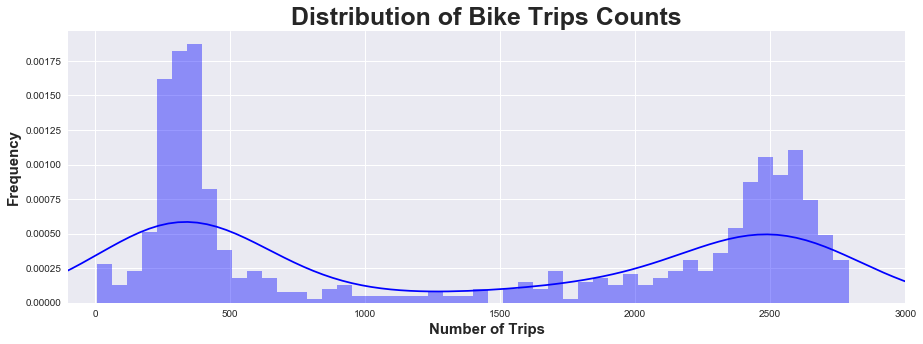

In [7]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_df.trip_count, color='b', bins=50)
plt.title('Distribution of Bike Trips Counts', size=TITLE_FONT_SIZE, weight='bold')
plt.xlim(-100, 3000)
plt.xlabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.show()

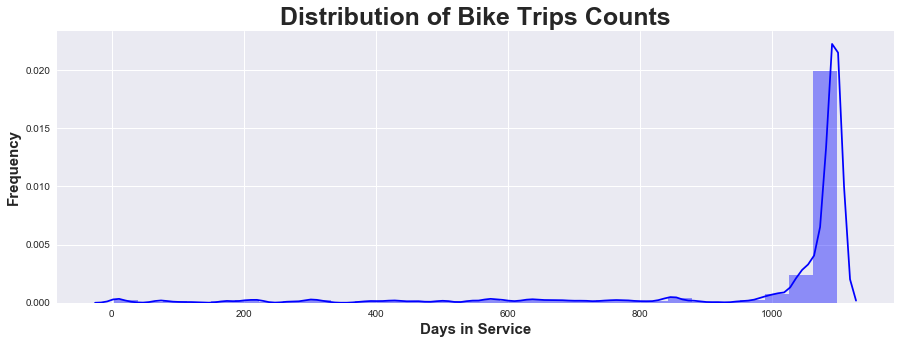

In [8]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_df.days_in_service, color='b', bins=30)
plt.title('Distribution of Bike Trips Counts', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Days in Service', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.show()

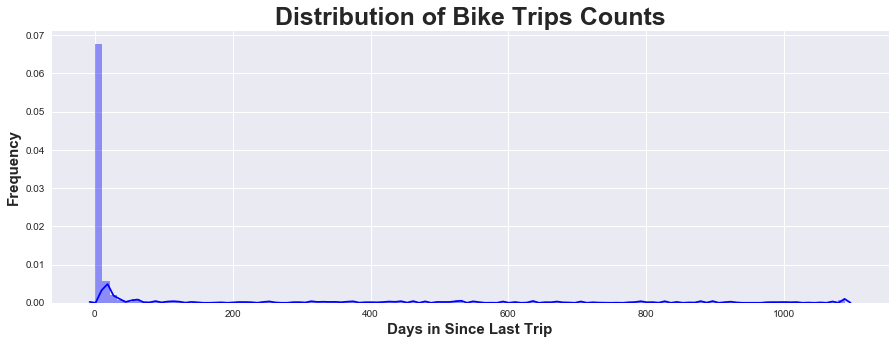

In [9]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_df.days_since_last_trip, color='b', bins=100)
plt.title('Distribution of Bike Trips Counts', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Days in Since Last Trip', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.show()

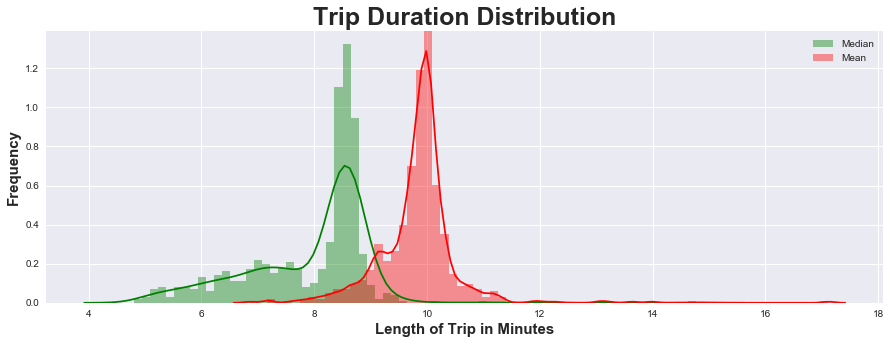

In [10]:
plt.subplots(figsize=(15,5))
ax = sns.distplot(bike_df.median_usage_time_per_trip/60., color='g', bins=70)
sns.distplot(bike_df.mean_usage_time_per_trip/60., color='r', bins=70, ax=ax)
plt.title('Trip Duration Distribution', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Length of Trip in Minutes', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')
plt.legend(['Median', 'Mean'], loc='best')
plt.show()

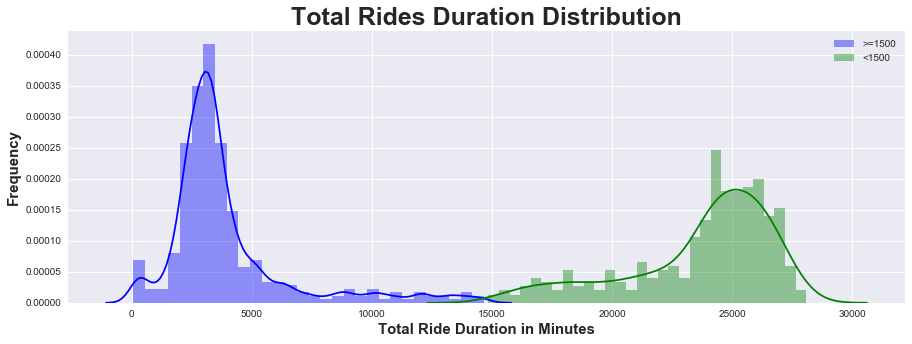

In [11]:
plt.subplots(figsize=(15,5))

sns.distplot(bike_df[bike_df.trip_count < 1500].total_usage_time/60., color='b', bins=30)
sns.distplot(bike_df[bike_df.trip_count >= 1500].total_usage_time/60., color='g', bins=30)


plt.title('Total Rides Duration Distribution', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Total Ride Duration in Minutes', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Frequency', size=LABEL_FONT_SIZE, weight='bold')

plt.legend(['>=1500', '<1500'], loc='best')
plt.show()

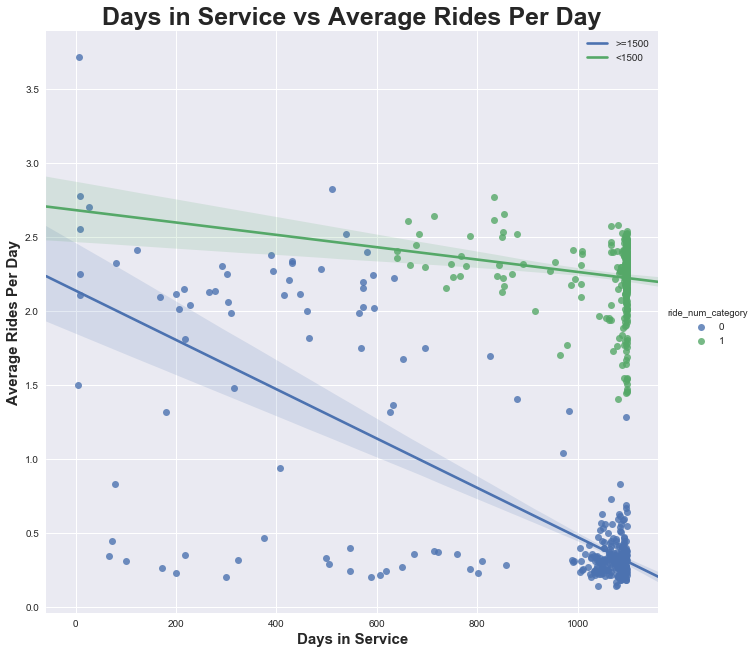

In [12]:
sns.lmplot(x='days_in_service', y='mean_rides_per_day', data=bike_df, hue='ride_num_category', size=10)
plt.title('Days in Service vs Average Rides Per Day', size=TITLE_FONT_SIZE, weight='bold')
plt.xlabel('Days in Service', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Average Rides Per Day', size=LABEL_FONT_SIZE, weight='bold')

plt.legend(['>=1500', '<1500'], loc='best')
plt.show()

# Write to File

In [ ]:
bike_df.to_csv('../clean_data/bayareabikeshare/bike_data_cleaned.csv', encoding='utf-8')

In [13]:
bike_df.shape

(700, 10)